# COGS 108 - Final Project 

# Overview

*Fill in your overview here*

# Name & GitHub ID

- Name: Tai Le
- GitHub Username: tnl001

# Research Question

What is the relationship between the amount of violent and violent related crimes and the parks' hour of operation in San Diego?

## Background and Prior Work

*Fill in your background and prior work here* 

References (include links):
- 1)
- 2)

# Hypothesis


Violent and violent related crimes tend to fall within the operating hour of San Diego parks.

# Dataset(s)

Dataset Name: San Diego Crime Data 2018
- Link to the dataset: http://seshat.datasd.org/pd/pd_calls_for_service_2018_datasd.csv
- Number of observations: 570459
- Description: This dataset contains the crime calls that were made and the type of crime that were reported in 2018

Dataset Name: San Diego Crime Data 2019
- Link to the dataset: http://seshat.datasd.org/pd/pd_calls_for_service_2019_datasd.csv
- Number of observations: 590967
- Description: This dataset contains the crime calls that were made and the type of crime that were reported in 2019

Dataset Name: San Diego Crime Data 2020
- Link to the dataset: http://seshat.datasd.org/pd/pd_calls_for_service_2020_datasd.csv
- Number of observations: 522569
- Description: This dataset contains the crime calls that were made and the type of crime that were reported in 2020

Dataset Name: San Diego Crime Crime Call Types
- Link to the dataset: http://seshat.datasd.org/pd/pd_cfs_calltypes_datasd.csv
- Number of observations: 289
- Description: This dataset contains codes of call type and their associated description

Dataset Name: San Diego Police Department Beat Codes
- Link to the dataset: http://seshat.datasd.org/pd/pd_beat_neighborhoods_datasd.csv
- Number of observations: 125
- Description: This dataset contains beat codes that are associated with San Diego neighborhoods

Dataset Name: San Diego Parks
- Link to the dataset: https://github.com/COGS108/individual_fa20/blob/master/data/yelp_SD_parks.csv
- Number of observations: 833
- Description: This dataset includes San Diego parks' names and zipcodes

I plan to combine the 2018, 2019, and 2020 crime call datasets into one big dataset. Then, I plan to use the call type datasets to match the call codes that are used in the crime call datasets. In addition to that, I will also use the beat codes dataset to match the description with the beat codes that are used in the crime call dataset. This way, I will be able to know which neighborhood each call was made from. Lastly, I plan to use the San Diego Parks dataset to identify which park to look at for each neighborhood.

# Setup

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

import patsy
import statsmodels.api as sm

from scipy import stats
from scipy.stats import normaltest

from sklearn import preprocessing

import warnings
warnings.filterwarnings('ignore')

pd.set_option('precision', 2)

In [2]:
sns.set()
sns.set_context('talk')

# Data Cleaning

The provided datasets contain fragments of the ideal dataset that I proposed. Thus, I had to combine different information across all of them in order to obtain what I wanted. The combination of datasets created a very large dataset that has over 1.5 millions observations. Thus, I had to narrow down the types of crime that I thought was the most relevant to my question. In addition, there are also inconsistencies in the labeling of parks' names and neighborhoods' names between datasets, and the structure of some columns also needed major changes. Overall, I tried to keep the final dataframe as coherent with the known facts as I can.

Load in the datasets

In [3]:
crime_2020 = pd.read_csv('pd_calls_for_service_2020_datasd.csv')
crime_2019 = pd.read_csv('pd_calls_for_service_2019_datasd.csv')
crime_2018 = pd.read_csv('pd_calls_for_service_2018_datasd.csv')
call_types = pd.read_csv('pd_cfs_calltypes_datasd.csv')
pd_beat_codes = pd.read_csv('pd_beat_neighborhoods_datasd.csv')
parks_info = pd.read_csv('yelp_SD_parks.csv')

In [4]:
parks_info.shape

(833, 10)

Here, I'm taking a quick look at what the data looks like

In [5]:
crime_2020.head()

,incident_num,date_time,day_of_week,address_number_primary,address_dir_primary,address_road_primary,address_sfx_primary,address_dir_intersecting,address_road_intersecting,address_sfx_intersecting,call_type,disposition,beat,priority
0,E20010000001,2020-01-01 00:00:09,4,400,NaN,06TH,AVE,NaN,NaN,NaN,11-8,A,523,0
1,E20010000002,2020-01-01 00:00:20,4,5000,NaN,UNIVERSITY,AVE,NaN,NaN,NaN,FD,K,826,2
2,E20010000003,2020-01-01 00:00:21,4,800,NaN,SAWTELLE,AVE,NaN,NaN,NaN,AU1,W,434,1
3,E20010000004,2020-01-01 00:00:32,4,5000,NaN,UNIVERSITY,AVE,NaN,NaN,NaN,FD,K,826,2
4,E20010000005,2020-01-01 00:00:42,4,5200,NaN,CLAIREMONT MESA,BLV,NaN,NaN,NaN,415V,K,111,1


In [6]:
crime_2019.head()

,incident_num,date_time,day_of_week,address_number_primary,address_dir_primary,address_road_primary,address_sfx_primary,address_dir_intersecting,address_road_intersecting,address_sfx_intersecting,call_type,disposition,beat,priority
0,E19010000001,2019-01-01 00:00:01,1,3800,NaN,NATIONAL,AVE,NaN,NaN,NaN,AU1,DUP,441,1
1,E19010000002,2019-01-01 00:00:04,1,6500,NaN,REFLECTION,DR,NaN,NaN,NaN,415,K,321,2
2,E19010000003,2019-01-01 00:00:09,1,0,NaN,06TH,AVE,NaN,ISLAND,NaN,FD,K,523,2
3,E19010000004,2019-01-01 00:00:19,1,0,NaN,VESTA,ST,NaN,MAIN,NaN,AU1,W,511,1
4,E19010000005,2019-01-01 00:00:31,1,0,NaN,04TH,AVE,NaN,ISLAND,NaN,586,CAN,523,4


Taking a look at the call_types dataset

In [7]:
call_types

,call_type,description,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,1016,PRISONER IN CUSTODY,NaN,NaN,NaN
1,1016PT,PTU (PRISONER TRANSPORT),NaN,NaN,NaN
2,1016QC,SHOPLIFTER/QUICK CITE,NaN,NaN,NaN
3,1021,PHONE YOUR STATION,NaN,NaN,NaN
4,1021H,PHONE YOUR HOME,NaN,NaN,NaN
...,...,...,...,...,...
284,TLO,TERRORISM LIAISON OFFICER,NaN,NaN,NaN
285,TP,TRAFFIC PURSUIT,NaN,NaN,NaN
286,TRO,"TRO VIOLATION, REPORT",NaN,NaN,NaN
287,VARDA,VARDA ALARM,NaN,NaN,NaN


Dropping the 3 Unnamed columns

In [8]:
call_types = call_types.dropna(axis=1)
call_types = call_types.drop_duplicates('call_type')

I noticed that there are some inconsistency with the 11-6, 11-7, and 11-8 call type codes when opening them in Excel and reading them as csv using pandas. I replace the inconsistent values with the correct values.

In [9]:
for n in call_types['call_type'].values: 
    call_types['call_type'].replace(to_replace='6-Nov', value='11-6', inplace=True)
    call_types['call_type'].replace(to_replace='7-Nov', value='11-7', inplace=True)
    call_types['call_type'].replace(to_replace='8-Nov', value='11-8', inplace=True)

Merging the cl_crimes with call_types using the left outer joint method. This way, I will have the description from call_types for each call type in cl_crimes.

In [10]:
cl_crimes = pd.concat([crime_2018, crime_2019, crime_2020]).reset_index(drop=True)

In [11]:
cl_crimes = cl_crimes.merge(call_types, how='left')
cl_crimes

,incident_num,date_time,day_of_week,address_number_primary,address_dir_primary,address_road_primary,address_sfx_primary,address_dir_intersecting,address_road_intersecting,address_sfx_intersecting,call_type,disposition,beat,priority,description
0,E18010000001,2018-01-01 00:00:09,0,0,NaN,MONROE,AVE,NaN,PARK,NaN,FD,K,624,2,FLAG DOWN/FIELD INITIATED
1,E18010000002,2018-01-01 00:00:41,0,0,NaN,MAIN,ST,NaN,THOR,NaN,AU1,W,511,1,ALL UNITS INFORMATION-PRI 1
2,E18010000003,2018-01-01 00:00:52,0,4300,NaN,OCEAN,BLV,NaN,NaN,NaN,1016,A,122,2,PRISONER IN CUSTODY
3,E18010000004,2018-01-01 00:00:55,0,4500,NaN,BOYLSTON,ST,NaN,NaN,NaN,AU1,W,445,1,ALL UNITS INFORMATION-PRI 1
4,E18010000005,2018-01-01 00:00:56,0,0,NaN,04TH,AVE,NaN,ISLAND,NaN,1151,O,523,3,PED STOP/FIELD INTERVIEW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1683990,E20120001602,2020-12-01 23:23:01,3,1200,NaN,K,ST,NaN,NaN,NaN,MPSSTP,K,521,2,TRAFFIC STOP FROM THE MOBILE COMPUTER
1683991,E20120001605,2020-12-01 23:28:18,3,5800,NaN,STREAMVIEW,DR,NaN,NaN,NaN,417,K,823,0,THREATENING W/WEAPON
1683992,E20120001608,2020-12-01 23:33:18,3,100,E,CALLE PRIMERA,NaN,NaN,NaN,NaN,T,K,712,2,TRAFFIC STOP WITH PLATE
1683993,E20120001616,2020-12-01 23:48:27,3,100,NaN,06TH,AVE,NaN,NaN,NaN,SELENF,K,521,3,SELECTIVE ENFORCEMENT


Dropping the unnecessary columns

In [12]:
cl_crimes = cl_crimes.drop(labels=['address_dir_intersecting', 'address_road_intersecting', 
                                           'address_sfx_intersecting', 'address_dir_primary', 
                                           'address_number_primary', 'address_road_primary',
                                           'address_sfx_primary'], axis=1)

In [13]:
cl_crimes.head()

,incident_num,date_time,day_of_week,call_type,disposition,beat,priority,description
0,E18010000001,2018-01-01 00:00:09,0,FD,K,624,2,FLAG DOWN/FIELD INITIATED
1,E18010000002,2018-01-01 00:00:41,0,AU1,W,511,1,ALL UNITS INFORMATION-PRI 1
2,E18010000003,2018-01-01 00:00:52,0,1016,A,122,2,PRISONER IN CUSTODY
3,E18010000004,2018-01-01 00:00:55,0,AU1,W,445,1,ALL UNITS INFORMATION-PRI 1
4,E18010000005,2018-01-01 00:00:56,0,1151,O,523,3,PED STOP/FIELD INTERVIEW


In [14]:
# 'DUP' and 'V' stands for duplicate calls 
rows_to_drop = cl_crimes[(cl_crimes['disposition'] == 'DUP') | (cl_crimes['disposition'] == 'V')]
cl_crimes = cl_crimes.drop(rows_to_drop.index)

In [15]:
cl_crimes

,incident_num,date_time,day_of_week,call_type,disposition,beat,priority,description
0,E18010000001,2018-01-01 00:00:09,0,FD,K,624,2,FLAG DOWN/FIELD INITIATED
1,E18010000002,2018-01-01 00:00:41,0,AU1,W,511,1,ALL UNITS INFORMATION-PRI 1
2,E18010000003,2018-01-01 00:00:52,0,1016,A,122,2,PRISONER IN CUSTODY
3,E18010000004,2018-01-01 00:00:55,0,AU1,W,445,1,ALL UNITS INFORMATION-PRI 1
4,E18010000005,2018-01-01 00:00:56,0,1151,O,523,3,PED STOP/FIELD INTERVIEW
...,...,...,...,...,...,...,...,...
1683990,E20120001602,2020-12-01 23:23:01,3,MPSSTP,K,521,2,TRAFFIC STOP FROM THE MOBILE COMPUTER
1683991,E20120001605,2020-12-01 23:28:18,3,417,K,823,0,THREATENING W/WEAPON
1683992,E20120001608,2020-12-01 23:33:18,3,T,K,712,2,TRAFFIC STOP WITH PLATE
1683993,E20120001616,2020-12-01 23:48:27,3,SELENF,K,521,3,SELECTIVE ENFORCEMENT


The beat code will determine which neighborhood it is that the crime occured. Here, I'm taking a quick look at the beat code dataset

In [16]:
pd_beat_codes.head()

,Beat,Neighborhood
0,111,Clairemont Mesa East
1,112,Clairemont Mesa West
2,113,Bay Ho
3,114,North Clairemont
4,115,University City


Renaming the columns so that they are all in lowercase.

In [17]:
pd_beat_codes.columns = ['beat', 'neighborhood']

Merging the cl_crimes with pd_beat_codes using the left outer joint method. This way, I will have the neighborhood's name from pd_beat_codes for each beat code in cl_crimes.

In [18]:
cl_crimes = cl_crimes.merge(pd_beat_codes, how='left')

In [19]:
cl_crimes

,incident_num,date_time,day_of_week,call_type,disposition,beat,priority,description,neighborhood
0,E18010000001,2018-01-01 00:00:09,0,FD,K,624,2,FLAG DOWN/FIELD INITIATED,University Heights
1,E18010000002,2018-01-01 00:00:41,0,AU1,W,511,1,ALL UNITS INFORMATION-PRI 1,Barrio Logan
2,E18010000003,2018-01-01 00:00:52,0,1016,A,122,2,PRISONER IN CUSTODY,Pacific Beach
3,E18010000004,2018-01-01 00:00:55,0,AU1,W,445,1,ALL UNITS INFORMATION-PRI 1,Chollas View
4,E18010000005,2018-01-01 00:00:56,0,1151,O,523,3,PED STOP/FIELD INTERVIEW,Gaslamp
...,...,...,...,...,...,...,...,...,...
1653374,E20120001602,2020-12-01 23:23:01,3,MPSSTP,K,521,2,TRAFFIC STOP FROM THE MOBILE COMPUTER,East Village
1653375,E20120001605,2020-12-01 23:28:18,3,417,K,823,0,THREATENING W/WEAPON,Redwood Village
1653376,E20120001608,2020-12-01 23:33:18,3,T,K,712,2,TRAFFIC STOP WITH PLATE,San Ysidro
1653377,E20120001616,2020-12-01 23:48:27,3,SELENF,K,521,3,SELECTIVE ENFORCEMENT,East Village


Here, I'm just exploring the rows that contain NaN values

In [20]:
cl_crimes[cl_crimes.isna().any(axis=1)]

,incident_num,date_time,day_of_week,call_type,disposition,beat,priority,description,neighborhood
12,E18010000015,2018-01-01 00:02:44,0,1151,O,-1,3,PED STOP/FIELD INTERVIEW,NaN
17,E18010000023,2018-01-01 00:04:01,0,INFOCHP,K,-1,4,INFORMATION FOR CHP,NaN
84,E18010000098,2018-01-01 00:28:43,0,MPSSTP,O,-1,3,TRAFFIC STOP FROM THE MOBILE COMPUTER,NaN
184,E18010000208,2018-01-01 01:22:24,0,MPSSTP,K,-1,3,TRAFFIC STOP FROM THE MOBILE COMPUTER,NaN
293,E18010000325,2018-01-01 02:14:45,0,INFO,K,-1,3,INFORMATION FOR DISPATCHERS,NaN
...,...,...,...,...,...,...,...,...,...
1653058,E20120001176,2020-12-01 16:36:20,3,1186,K,-1,3,SPECIAL DETAIL,NaN
1653132,E20120001263,2020-12-01 17:36:41,3,AU211,W,-1,1,ROBBERY-ALL UNITS INFORMATION,NaN
1653162,E20120001294,2020-12-01 17:59:42,3,INFO,W,-1,2,INFORMATION FOR DISPATCHERS,NaN
1653294,E20120001458,2020-12-01 20:32:31,3,1021,K,-1,3,PHONE YOUR STATION,NaN


Dropping all rows that contain NaN because:
- For the rows that have their beat code to be = -1, I have no where to find out why they were labeled like that
- For the rows that have their beat code to be < 111, it is obviously that these areas are not in the San Diego County
- With a massive amount of observations (over 1.5 millions), I decided that 39,424 observations that divide across all areas is an acceptable removal

In [21]:
cl_crimes = cl_crimes.dropna()
cl_crimes.shape

(1613955, 9)

Here, I'm focusing on a certain type of crime. Below are the call type codes that I used to extract the data:
1. 11-6: Discharging firearms
2. 207: Kidnapping in progress
3. 207R: Kidnapping report
4. 211: Robbery
5. 278: Child stealing
6. 415V: Disturbing peace with violence
7. 415W: Disturbing peace with[?] weapon
8. 417: Threatening with weapon

In [22]:
filtered_crimes = cl_crimes[(cl_crimes['call_type'] == '11-6') | (cl_crimes['call_type'] == '207') | 
                            (cl_crimes['call_type'] == '207R') | (cl_crimes['call_type'] == '211') |
                            (cl_crimes['call_type'] == '278') | (cl_crimes['call_type'] == '415V') |
                            (cl_crimes['call_type'] == '415W') | (cl_crimes['call_type'] == '418')]

# Each call will be counted as 1
# This column will be used later to count the total amount of calls that were made in a certain area/park
filtered_crimes['total_call'] = 1

In [23]:
filtered_crimes.isna().any()

incident_num    False
date_time       False
day_of_week     False
call_type       False
disposition     False
beat            False
priority        False
description     False
neighborhood    False
total_call      False
dtype: bool

In [24]:
filtered_crimes = filtered_crimes.reset_index(drop=True)
filtered_crimes.head()

,incident_num,date_time,day_of_week,call_type,disposition,beat,priority,description,neighborhood,total_call
0,E18010000022,2018-01-01 00:03:51,0,415V,K,322,1,DISTURBING PEACE W/VIOLENCE,Allied Gardens,1
1,E18010000037,2018-01-01 00:08:30,0,415V,A,518,1,DISTURBING PEACE W/VIOLENCE,South Park,1
2,E18010000041,2018-01-01 00:10:02,0,11-6,U,441,0,DISCHARGING FIREARMS,Mountain View,1
3,E18010000048,2018-01-01 00:11:24,0,11-6,K,512,0,DISCHARGING FIREARMS,Logan Heights,1
4,E18010000067,2018-01-01 00:18:29,0,415V,A,122,1,DISTURBING PEACE W/VIOLENCE,Pacific Beach,1


After doing some exploring and checking on the filtered_crimes dataset, I noticed that the day_of_week column is filled with extremely inconsistent data. Below in the code cell is what I discovered about the pattern in the 2018, 2019, and 2020 datasets. Then, I attempted to cleaning this up by using the following labeling structure for all 3 years:
- 1 = Sunday
- 2 = Monday
- 3 = Tuesday
- 4 = Wednesday
- 5 = Thursday
- 6 = Friday
- 7 = Saturday

In [25]:
# 2018 codes
    # 0 = Monday
    # 1 = Tuesday
    # 2 = Wednesday
    # 3 = Thusday
    # 4 = Friday
    # 5 = Saturday
    # 6 = Sunday

# 2019 codes
    # 0 = Monday (1-9)
    # 1 = Tueday (1-9), 1 = Sunday (10,11,12)
    # 2 = Wednesday (1-9), 2 = Monday (10,11,12)
    # 3 = Thusday (1-9), 3 = Tuesday (10,11,12)
    # 4 = Friday (1-9), 4 = Wednesday (10,11,12)
    # 5 = Saturday (1-9), 5 = Thursday (10,11,12)
    # 6 = Sunday (1-9), 6 = Friday (10,11,12)

# 2020 codes
    # 1 = Sunday
    # 2 = Monday
    # 3 = Tuesday
    # 4 = Wednesday
    # 5 = Thursday
    # 6 = Friday
    # 7 = Saturday
    
# 19592 is where 2018 -> 2019
# 34630 is where 2019 starts the inconsitency
# 38792 is where 2019 -> 2020

# Fix the day of week for the 2018 data
for i in range(0, 19592):
    if filtered_crimes['day_of_week'][i] == 0:
        filtered_crimes['day_of_week'][i] = 2
    elif filtered_crimes['day_of_week'][i] == 1:
        filtered_crimes['day_of_week'][i] = 3
    elif filtered_crimes['day_of_week'][i] == 2:
        filtered_crimes['day_of_week'][i] = 4
    elif filtered_crimes['day_of_week'][i] == 3:
        filtered_crimes['day_of_week'][i] = 5
    elif filtered_crimes['day_of_week'][i] == 4:
        filtered_crimes['day_of_week'][i] = 6
    elif filtered_crimes['day_of_week'][i] == 5:
        filtered_crimes['day_of_week'][i] = 7
    elif filtered_crimes['day_of_week'][i] == 6:
        filtered_crimes['day_of_week'][i] = 1 

In [26]:
# Fix the day of week for the 2019 data
for i in range(19592, 34630):
    if filtered_crimes['day_of_week'][i] == 0:
        filtered_crimes['day_of_week'][i] = 2
    elif filtered_crimes['day_of_week'][i] == 1:
        filtered_crimes['day_of_week'][i] = 3
    elif filtered_crimes['day_of_week'][i] == 2:
        filtered_crimes['day_of_week'][i] = 4
    elif filtered_crimes['day_of_week'][i] == 3:
        filtered_crimes['day_of_week'][i] = 5
    elif filtered_crimes['day_of_week'][i] == 4:
        filtered_crimes['day_of_week'][i] = 6
    elif filtered_crimes['day_of_week'][i] == 5:
        filtered_crimes['day_of_week'][i] = 7
    elif filtered_crimes['day_of_week'][i] == 6:
        filtered_crimes['day_of_week'][i] = 1 

In [27]:
type_time_called = filtered_crimes.groupby('description').sum()
type_time_called = type_time_called.drop(labels=['day_of_week', 'beat', 'priority'], axis=1)

neighbor_time_called = filtered_crimes.groupby('neighborhood').sum()
neighbor_time_called = neighbor_time_called.drop(labels=['day_of_week', 'beat', 'priority'], axis=1)

filtered_crimes['name'] = filtered_crimes['neighborhood']

In [28]:
parks_info.head()

,name,address,phone,id,url,rating,review_count,longitude,latitude,is_closed
0,Balboa Park,"1549 El Prado San Diego, CA 92101",1.62e+10,9M_FW_-Ipx93I36w-_ykBg,https://www.yelp.com/biz/balboa-park-san-diego...,5.0,2105,-117.15,32.73,False
1,Civita Park,"7960 Civita Blvd San Diego, CA 92108",NaN,3AEHjqNrTmggA6G9VdhQfg,https://www.yelp.com/biz/civita-park-san-diego...,4.5,46,-117.15,32.78,False
2,Waterfront Park,"1600 Pacific Hwy San Diego, CA 92101",1.62e+10,3unbJeYrn1RmInZGmjp80g,https://www.yelp.com/biz/waterfront-park-san-d...,4.5,242,-117.17,32.72,False
3,Trolley Barn Park,"Adams Ave And Florida St San Diego, CA 92116",NaN,PvHxIYrmaiFKdWUDTMDzcg,https://www.yelp.com/biz/trolley-barn-park-san...,4.5,102,-117.14,32.76,False
4,Bay View Park,"413 1st St Coronado, CA 92118",NaN,6IF4VB9-fkv_F-LBvG8ppQ,https://www.yelp.com/biz/bay-view-park-coronad...,5.0,42,-117.18,32.70,False


In [29]:
parks_info = parks_info.drop(labels=['phone', 'rating', 'review_count', 'id'], axis=1)

In [30]:
parks_info.head()

,name,address,url,longitude,latitude,is_closed
0,Balboa Park,"1549 El Prado San Diego, CA 92101",https://www.yelp.com/biz/balboa-park-san-diego...,-117.15,32.73,False
1,Civita Park,"7960 Civita Blvd San Diego, CA 92108",https://www.yelp.com/biz/civita-park-san-diego...,-117.15,32.78,False
2,Waterfront Park,"1600 Pacific Hwy San Diego, CA 92101",https://www.yelp.com/biz/waterfront-park-san-d...,-117.17,32.72,False
3,Trolley Barn Park,"Adams Ave And Florida St San Diego, CA 92116",https://www.yelp.com/biz/trolley-barn-park-san...,-117.14,32.76,False
4,Bay View Park,"413 1st St Coronado, CA 92118",https://www.yelp.com/biz/bay-view-park-coronad...,-117.18,32.70,False


In [31]:
parks_info = parks_info.drop_duplicates('name')

In [32]:
community_park_extract = []

for e in filtered_crimes['name'].unique():
    for i in parks_info['name'].unique():
        if (e in i) & ('Community Park' in i):
            community_park_extract.append(i)

In [33]:
community_park_extract

['Allied Gardens Community Park',
 'North Park Community Park',
 'Mira Mesa Community Park',
 'Linda Vista Community Park',
 'Tierrasanta Community Park and Recreation Center',
 'Princess Del Cerro Community Park',
 'Lake Murray Community Park',
 'Carmel Mountain Ranch Community Park']

Here, I'm extracting the parks' names that match with the existing neighbohood names in filtered_crimes. In addition, some parks' names contain elements that would in general fit the description of a park's name but they are not actually parks. In order to account for that, I had to manually remove certain features that would otherwise falsely categorize a name.

In [34]:
park_extract = []

# First, loop through the filtered_crimnes dataset to get the neighborhoods' names
# Then, loop through the parks_info dataset to get the parks' names
# If a neighborhood's name is contained within a park's name and matches other condition, then extract it
for e in filtered_crimes['name'].unique():
    for i in parks_info['name'].unique():
        if (e in i) & (('Park' in i) | ('Shores' in i))& ('Community' not in i)\
        & ('Private' not in i) & ('Dog' not in i) & ('Optometry' not in i)\
        & ('Massage' not in i) & ('Produce' not in i) & ('Nursery' not in i)\
        & ('Skate' not in i) & ('Parking' not in i) & ('Urbn' not in i)\
        & ('Mini' not in i) & ('619 Spirits' not in i) & ('Taste' not in i)\
        & ('Pure Project' not in i) & ('Kids' not in i) & ('North Park' not in i)\
        & ('Lifeguard' not in i):
            park_extract.append(i)

In [35]:
len(park_extract)

32

In [36]:
# Combining both community park and normal park lists
park_extract = park_extract + community_park_extract

In [37]:
# Creating a new dataframe that contains all of the parks' names
cl_park_data = pd.DataFrame(data=park_extract, columns=['name'])
cl_park_data = cl_park_data.drop_duplicates('name').reset_index(drop=True)

In [38]:
cl_park_data

,name
0,Mountain View Park
1,Grantville Neighborhood Park
2,Petco Park
3,Ocean Beach Park
4,Embarcadero Marina Park North
5,Embarcadero Marina Park South
6,J Street Marina Bayside Park
7,Villa La Jolla Park
8,La Jolla Shores
9,La Jolla Underwater Park


In [39]:
# Dropping [4]Embarcadero Marina Park North because it is not the actual main park and thus no information could be found
# Dropping [6]J Street Marina Bayside Park because there is no associated neighborhood
# Dropping [7]Villa La Jolla Park because I decided to keep La Jolla Shores Park the representative of La Jolla parks
# Dropping [9]La Jolla Underwater Park for the same reason as above
# Dropping [12]Bay Park because it is not an actual park but a neighborhood
# Dropping [13]Kearny Mesa Park because it is a part of the [14]Kearny Mesa Park & Recreation Center
# Dropping [21]Border Field State Park because it is currently closed and thus no information could be found
# Dropping [29]Miramar Lakeview Park because I decided to keep Miramar Overlook Park the representative
cl_park_data = cl_park_data.drop([4, 6, 7, 9, 12, 13, 21, 29]).reset_index(drop=True)

In [40]:
filtered_crimes['park_name'] = ''

In [41]:
neighborhoods = []

for neighborhood in filtered_crimes['name']:
    for name_of_park in cl_park_data['name']:
        if neighborhood in name_of_park:
            neighborhoods.append(neighborhood)  

In [42]:
neighborhoods

['Allied Gardens',
 'Mountain View',
 'Grantville',
 'Petco Park',
 'Ocean Beach',
 'Marina',
 'La Jolla',
 'University Heights',
 'Grantville',
 'North Park',
 'University Heights',
 'Mira Mesa',
 'Ocean Beach',
 'Mountain View',
 'Mountain View',
 'Linda Vista',
 'Bay Park',
 'Marina',
 'Mira Mesa',
 'Grantville',
 'Mountain View',
 'Ocean Beach',
 'Mountain View',
 'Kearny Mesa',
 'Mountain View',
 'Linda Vista',
 'Grantville',
 'North Park',
 'Petco Park',
 'Mira Mesa',
 'North Park',
 'La Jolla',
 'Emerald Hills',
 'Scripps Ranch',
 'Ocean Beach',
 'La Jolla',
 'La Jolla',
 'Balboa Park',
 'Mountain View',
 'Ocean Beach',
 'Linda Vista',
 'Grant Hill',
 'La Jolla',
 'Mira Mesa',
 'Mountain View',
 'Emerald Hills',
 'Kearny Mesa',
 'Scripps Ranch',
 'North Park',
 'Sabre Springs',
 'Ocean Beach',
 'University Heights',
 'Encanto',
 'Allied Gardens',
 'Ocean Beach',
 'Scripps Ranch',
 'Grantville',
 'Marina',
 'Mountain View',
 'North Park',
 'North Park',
 'Mira Mesa',
 'Grantville

Here, I'm extracting the neighborhoods' names into a new dataframe and column using the same technique as when I was extracting the parks' names.

In [43]:
cl_neighborhood_data = pd.DataFrame(data=neighborhoods, columns=['neighborhood_name'])
cl_neighborhood_data = cl_neighborhood_data.drop_duplicates('neighborhood_name').reset_index(drop=True)

In [44]:
cl_park_data['neighborhood'] = ''

In [45]:
for i in range(0, len(cl_park_data['name'].tolist())):
    for e in cl_neighborhood_data['neighborhood_name'].tolist():
        if e in cl_park_data['name'][i]:
            cl_park_data['neighborhood'][i] = e      

In [46]:
cl_park_data

,name,neighborhood
0,Mountain View Park,Mountain View
1,Grantville Neighborhood Park,Grantville
2,Petco Park,Petco Park
3,Ocean Beach Park,Ocean Beach
4,Embarcadero Marina Park South,Marina
5,La Jolla Shores,La Jolla
6,University Heights Park,University Heights
7,Mission Bay Park,Mission Bay Park
8,Kearny Mesa Park & Recreation Center,Kearny Mesa
9,Emerald Hills Park,Emerald Hills


In [47]:
def get_total_call(nbh_name):    
    return filtered_crimes[filtered_crimes['name'].str.contains(nbh_name)].groupby('name').sum()['total_call'].values[0]

In [48]:
cl_park_data['total_call'] = cl_park_data['neighborhood'].apply(get_total_call)

In [49]:
cl_park_data

,name,neighborhood,total_call
0,Mountain View Park,Mountain View,1196
1,Grantville Neighborhood Park,Grantville,581
2,Petco Park,Petco Park,392
3,Ocean Beach Park,Ocean Beach,1331
4,Embarcadero Marina Park South,Marina,662
5,La Jolla Shores,La Jolla,681
6,University Heights Park,University Heights,489
7,Mission Bay Park,Mission Bay Park,303
8,Kearny Mesa Park & Recreation Center,Kearny Mesa,618
9,Emerald Hills Park,Emerald Hills,203


In [50]:
# I tried creating a Google Places API in Google Cloud but it kept returning an error message about retrieving my ClientID
# Because of this error and with limited time, I decided to manually look up the hours of each park
# In addition to these reasons, I also want the static (current) hours of the parks; API might change the result in the future
# I might revamp this part later on when I fix the error
# NOTE: '0-0' means that the park is closed on that day
# Business hour of each park:
#     1. Mountain View Park: 0-24 (Google)
#     2. Grantville Neighborhood Park: 0-24
#     3. Petco Park: 9-21 (Yelp)
#     4. Ocean Beach Park: hour varies (Google)
#     5. Embarcadero Marina Park South: 6-22.5 (Google)
#     6. La Jolla Shores: 0-24
#     7. University Heights Park: 6-22 (Google)
#     8. Mission Bay Park: 4-24 (Yelp)
#     9. Kearny Mesa Park & Recreation Center: 10-20 (Google - Open/Close hours averaged out)
#     10. Emerald Hills Park: 7-20 (Google)
#     11. Scripps Ranch Villages Butterfly Park: 9-17 (Google)
#     12. Balboa Park: 0-24 (Google)
#     13. Grant Hill Park: 0-24 (Google)
#     14. Sabre Springs Park: 9-17 (Google)
#     15. Encanto Park: 5.5-23 (Google)
#     16. Golden Hill Park: 7-18.5 (Google)
#     17. Horton Plaza Park: 5-24 (Google)
#     18. Nestor Neighborhood Park: 6-18 (Google)
#     19. Old Town San Diego State Historic Park: 10-17 (Google)
#     20. San Carlos Park: 11-21 (Google - Mostly)
#     21. Tijuana River Valley Regional Park: 8-20 (Google)
#     22. Miramar Overlook Park: 9-21 (Google)
#     23. Sunset Cliffs Natural Park: 0-24 (Google)
#     24. Allied Gardens Community Park: 11-21 (Google - Mostly)
#     25. North Park Community Park: 0-24 (Google)
#     26. Mira Mesa Community Park: 0-24 (Google)
#     27. Linda Vista Community Park: 0-24 
#     28. Tierrasanta Community Park and Recreation Center: hour varies (Google)
#     29. Princess Del Cerro Community Park: 6-22 (Google)
#     30. Lake Murray Community Park: 7-20 (Google)
#     31. Carmel Mountain Ranch Community Park: hour varies (Google)
cl_park_data['mon'] = ''
cl_park_data['tue'] = ''
cl_park_data['wed'] = ''
cl_park_data['thur'] = ''
cl_park_data['fri'] = ''
cl_park_data['sat'] = ''
cl_park_data['sun'] = ''

def assign_time(park_name, mon, tue, wed, thur, fri, sat, sun):
    cl_park_data.loc[cl_park_data['name'] == park_name, 'mon'] = mon
    cl_park_data.loc[cl_park_data['name'] == park_name, 'tue'] = tue
    cl_park_data.loc[cl_park_data['name'] == park_name, 'wed'] = wed
    cl_park_data.loc[cl_park_data['name'] == park_name, 'thur'] = thur
    cl_park_data.loc[cl_park_data['name'] == park_name, 'fri'] = fri
    cl_park_data.loc[cl_park_data['name'] == park_name, 'sat'] = sat
    cl_park_data.loc[cl_park_data['name'] == park_name, 'sun'] = sun

assign_time('Mountain View Park', '0-24', '0-24', '0-24', '0-24', '0-24', '0-24', '0-24')
assign_time('Grantville Neighborhood Park', '0-24', '0-24', '0-24', '0-24', '0-24', '0-24', '0-24')
assign_time('Petco Park', '9-21', '9-21', '9-21', '9-21', '9-21', '9-21', '9-21')
assign_time('Ocean Beach Park', '10-21', '10-21', '10-21', '10-21', '10-19', '9-16', '0-0')
assign_time('Embarcadero Marina Park South', '6-22.5', '6-22.5', '6-22.5', '6-22.5', '6-22.5', '6-22.5', '6-22.5')
assign_time('La Jolla Shores', '0-24', '0-24', '0-24', '0-24', '0-24', '0-24', '0-24')
assign_time('University Heights Park', '6-22', '6-22', '6-22', '6-22', '6-22', '6-22', '6-22')
assign_time('Mission Bay Park', '4-24', '4-24', '4-24', '4-24', '4-24', '4-24', '4-24')
assign_time('Kearny Mesa Park & Recreation Center', '10-20', '10-21', '10-21', '10-21', '10-19', '9-17', '0-0')
assign_time('Emerald Hills Park', '7-20', '7-20', '7-20', '7-20', '7-20', '7-20', '7-20')
assign_time('Scripps Ranch Villages Butterfly Park', '9-17', '9-17', '9-17', '9-17', '9-17', '9-17', '9-17')
assign_time('Balboa Park', '0-24', '0-24', '0-24', '0-24', '0-24', '0-24', '0-24')
assign_time('Grant Hill Park', '0-24', '0-24', '0-24', '0-24', '0-24', '0-24', '0-24')
assign_time('Sabre Springs Park', '9-17', '9-17', '9-17', '9-17', '9-17', '9-17', '9-17')
assign_time('Encanto Park', '5.5-23', '5.5-23', '5.5-23', '5.5-23', '5.5-23', '5.5-23', '5.5-23')
assign_time('Golden Hill Park', '7-18.5', '7-18.5', '7-18.5', '7-18.5', '7-18.5', '7-18.5', '7-18.5')
assign_time('Horton Plaza Park', '5-24', '5-24', '5-24', '5-24', '5-24', '5-24', '5-24')
assign_time('Nestor Neighborhood Park', '6-18', '6-18', '6-18', '6-18', '6-18', '6-18', '6-18',)
assign_time('Old Town San Diego State Historic Park', '10-17', '10-17', '10-17', '10-17', '10-17', '10-17', '10-17',)
assign_time('San Carlos Park', '11-21', '11-21', '11-21', '11-21', '11-19', '9-17', '10-1')
assign_time('Tijuana River Valley Regional Park', '8-20', '8-20', '8-20', '8-20', '8-20', '8-20', '8-20')
assign_time('Miramar Overlook Park', '9-21', '9-21', '9-21', '9-21', '9-21', '9-21', '9-21')
assign_time('Sunset Cliffs Natural Park', '0-24', '0-24', '0-24', '0-24', '0-24', '0-24', '0-24')
assign_time('Allied Gardens Community Park', '11-21', '11-21', '11-21', '11-21', '11-20', '9-17', '9-15')
assign_time('North Park Community Park', '0-24', '0-24', '0-24', '0-24', '0-24', '0-24', '0-24')
assign_time('Mira Mesa Community Park', '0-24', '0-24', '0-24', '0-24', '0-24', '0-24', '0-24')
assign_time('Linda Vista Community Park', '0-24', '0-24', '0-24', '0-24', '0-24', '0-24', '0-24')
assign_time('Tierrasanta Community Park and Recreation Center', '13-21', '10-21', '12-21', '10-21', '14-21', '9-16', '10-16')
assign_time('Princess Del Cerro Community Park', '6-22', '6-22', '6-22', '6-22', '6-22', '6-22', '6-22')
assign_time('Lake Murray Community Park', '7-20', '7-20', '7-20', '7-20', '7-20', '7-20', '7-20')
assign_time('Carmel Mountain Ranch Community Park', '10-20', '9-21', '10-20', '10-21', '10-19', '9-17', '0-0')

In [51]:
cl_park_data

,name,neighborhood,total_call,mon,tue,wed,thur,fri,sat,sun
0,Mountain View Park,Mountain View,1196,0-24,0-24,0-24,0-24,0-24,0-24,0-24
1,Grantville Neighborhood Park,Grantville,581,0-24,0-24,0-24,0-24,0-24,0-24,0-24
2,Petco Park,Petco Park,392,9-21,9-21,9-21,9-21,9-21,9-21,9-21
3,Ocean Beach Park,Ocean Beach,1331,10-21,10-21,10-21,10-21,10-19,9-16,0-0
4,Embarcadero Marina Park South,Marina,662,6-22.5,6-22.5,6-22.5,6-22.5,6-22.5,6-22.5,6-22.5
5,La Jolla Shores,La Jolla,681,0-24,0-24,0-24,0-24,0-24,0-24,0-24
6,University Heights Park,University Heights,489,6-22,6-22,6-22,6-22,6-22,6-22,6-22
7,Mission Bay Park,Mission Bay Park,303,4-24,4-24,4-24,4-24,4-24,4-24,4-24
8,Kearny Mesa Park & Recreation Center,Kearny Mesa,618,10-20,10-21,10-21,10-21,10-19,9-17,0-0
9,Emerald Hills Park,Emerald Hills,203,7-20,7-20,7-20,7-20,7-20,7-20,7-20


In [52]:
cl_park_data['during'] = 0
cl_park_data['not_during'] = 0
cl_park_data

,name,neighborhood,total_call,mon,tue,wed,thur,fri,sat,sun,during,not_during
0,Mountain View Park,Mountain View,1196,0-24,0-24,0-24,0-24,0-24,0-24,0-24,0,0
1,Grantville Neighborhood Park,Grantville,581,0-24,0-24,0-24,0-24,0-24,0-24,0-24,0,0
2,Petco Park,Petco Park,392,9-21,9-21,9-21,9-21,9-21,9-21,9-21,0,0
3,Ocean Beach Park,Ocean Beach,1331,10-21,10-21,10-21,10-21,10-19,9-16,0-0,0,0
4,Embarcadero Marina Park South,Marina,662,6-22.5,6-22.5,6-22.5,6-22.5,6-22.5,6-22.5,6-22.5,0,0
5,La Jolla Shores,La Jolla,681,0-24,0-24,0-24,0-24,0-24,0-24,0-24,0,0
6,University Heights Park,University Heights,489,6-22,6-22,6-22,6-22,6-22,6-22,6-22,0,0
7,Mission Bay Park,Mission Bay Park,303,4-24,4-24,4-24,4-24,4-24,4-24,4-24,0,0
8,Kearny Mesa Park & Recreation Center,Kearny Mesa,618,10-20,10-21,10-21,10-21,10-19,9-17,0-0,0,0
9,Emerald Hills Park,Emerald Hills,203,7-20,7-20,7-20,7-20,7-20,7-20,7-20,0,0


Now, I want to categorize all of the calls that occured in the listed parks/neighborhoods into either 'during' or 'not_during'. To do this, I need to compare the time that the call occured (in hour) to the operating hour at that specific day. For example, if a call occured at 11pm on Thursday at park A, then I will compare 11pm to the operating hour of park A on Thursday. There are seven days in a week, so my function will compare the day first before comparing the hour.

In [53]:
# A function that categorizes time of call into 'during' and 'not_during'
# It takes in the name of a neighborhood as a parameter and this will be used in place of the park's name
# After that, the day_of_week and date_time columns of that neighborhood will be copied to two lists.
# Then, the operating hour of that park will be extracted
# By using the day_of_week data, the function will be able to compare the occured time to operating hour of that specific day
# If the hour falls within the operating hour, then it will increment 'during' by 1
# If not then it will increment 'not_during' by 1
# The function essentially does the same step 7 times for 7 days of the week
def time_categorize(name):
    dates = filtered_crimes[filtered_crimes['name'] == name]['day_of_week'].tolist()
    time_stamps = pd.to_datetime(filtered_crimes[filtered_crimes['name'] == name]['date_time']).dt.strftime('%H').tolist()
    
    for i in range(0, len(dates)):
        if dates[i] == 1:
            busi_hour = cl_park_data.loc[cl_park_data['neighborhood'] == name, 'sun'].values[0]
            open_time = float(busi_hour[:busi_hour.find('-')])
            close_time = float(busi_hour[busi_hour.find('-') + 1:])
            
            if (float(time_stamps[i]) >= open_time) & (float(time_stamps[i]) <= close_time):
                cl_park_data.loc[cl_park_data['neighborhood'] == name, 'during'] += 1
            elif (float(time_stamps[i]) < open_time) | (float(time_stamps[i]) > close_time):
                cl_park_data.loc[cl_park_data['neighborhood'] == name, 'not_during'] += 1
        elif dates[i] == 2:
            busi_hour = cl_park_data.loc[cl_park_data['neighborhood'] == name, 'mon'].values[0]
            open_time = float(busi_hour[:busi_hour.find('-')])
            close_time = float(busi_hour[busi_hour.find('-') + 1:])
            
            if (float(time_stamps[i]) >= open_time) & (float(time_stamps[i]) <= close_time):
                cl_park_data.loc[cl_park_data['neighborhood'] == name, 'during'] += 1
            elif (float(time_stamps[i]) < open_time) | (float(time_stamps[i]) > close_time):
                cl_park_data.loc[cl_park_data['neighborhood'] == name, 'not_during'] += 1
        elif dates[i] == 3:
            busi_hour = cl_park_data.loc[cl_park_data['neighborhood'] == name, 'tue'].values[0]
            open_time = float(busi_hour[:busi_hour.find('-')])
            close_time = float(busi_hour[busi_hour.find('-') + 1:])
            
            if (float(time_stamps[i]) >= open_time) & (float(time_stamps[i]) <= close_time):
                cl_park_data.loc[cl_park_data['neighborhood'] == name, 'during'] += 1
            elif (float(time_stamps[i]) < open_time) | (float(time_stamps[i]) > close_time):
                cl_park_data.loc[cl_park_data['neighborhood'] == name, 'not_during'] += 1
        elif dates[i] == 4:
            busi_hour = cl_park_data.loc[cl_park_data['neighborhood'] == name, 'wed'].values[0]
            open_time = float(busi_hour[:busi_hour.find('-')])
            close_time = float(busi_hour[busi_hour.find('-') + 1:])
            
            if (float(time_stamps[i]) >= open_time) & (float(time_stamps[i]) <= close_time):
                cl_park_data.loc[cl_park_data['neighborhood'] == name, 'during'] += 1
            elif (float(time_stamps[i]) < open_time) | (float(time_stamps[i]) > close_time):
                cl_park_data.loc[cl_park_data['neighborhood'] == name, 'not_during'] += 1
        elif dates[i] == 5:
            busi_hour = cl_park_data.loc[cl_park_data['neighborhood'] == name, 'thur'].values[0]
            open_time = float(busi_hour[:busi_hour.find('-')])
            close_time = float(busi_hour[busi_hour.find('-') + 1:])
            
            if (float(time_stamps[i]) >= open_time) & (float(time_stamps[i]) <= close_time):
                cl_park_data.loc[cl_park_data['neighborhood'] == name, 'during'] += 1
            elif (float(time_stamps[i]) < open_time) | (float(time_stamps[i]) > close_time):
                cl_park_data.loc[cl_park_data['neighborhood'] == name, 'not_during'] += 1
        elif dates[i] == 6:
            busi_hour = cl_park_data.loc[cl_park_data['neighborhood'] == name, 'fri'].values[0]
            open_time = float(busi_hour[:busi_hour.find('-')])
            close_time = float(busi_hour[busi_hour.find('-') + 1:])
            
            if (float(time_stamps[i]) >= open_time) & (float(time_stamps[i]) <= close_time):
                cl_park_data.loc[cl_park_data['neighborhood'] == name, 'during'] += 1
            elif (float(time_stamps[i]) < open_time) | (float(time_stamps[i]) > close_time):
                cl_park_data.loc[cl_park_data['neighborhood'] == name, 'not_during'] += 1
        elif dates[i] == 7:
            busi_hour = cl_park_data.loc[cl_park_data['neighborhood'] == name, 'sat'].values[0]
            open_time = float(busi_hour[:busi_hour.find('-')])
            close_time = float(busi_hour[busi_hour.find('-') + 1:])
            
            if (float(time_stamps[i]) >= open_time) & (float(time_stamps[i]) <= close_time):
                cl_park_data.loc[cl_park_data['neighborhood'] == name, 'during'] += 1
            elif (float(time_stamps[i]) < open_time) | (float(time_stamps[i]) > close_time):
                cl_park_data.loc[cl_park_data['neighborhood'] == name, 'not_during'] += 1

In [54]:
cl_park_data['neighborhood'].apply(time_categorize)
cl_park_data

,name,neighborhood,total_call,mon,tue,wed,thur,fri,sat,sun,during,not_during
0,Mountain View Park,Mountain View,1196,0-24,0-24,0-24,0-24,0-24,0-24,0-24,1196,0
1,Grantville Neighborhood Park,Grantville,581,0-24,0-24,0-24,0-24,0-24,0-24,0-24,581,0
2,Petco Park,Petco Park,392,9-21,9-21,9-21,9-21,9-21,9-21,9-21,263,129
3,Ocean Beach Park,Ocean Beach,1331,10-21,10-21,10-21,10-21,10-19,9-16,0-0,582,749
4,Embarcadero Marina Park South,Marina,662,6-22.5,6-22.5,6-22.5,6-22.5,6-22.5,6-22.5,6-22.5,461,201
5,La Jolla Shores,La Jolla,681,0-24,0-24,0-24,0-24,0-24,0-24,0-24,681,0
6,University Heights Park,University Heights,489,6-22,6-22,6-22,6-22,6-22,6-22,6-22,346,143
7,Mission Bay Park,Mission Bay Park,303,4-24,4-24,4-24,4-24,4-24,4-24,4-24,270,33
8,Kearny Mesa Park & Recreation Center,Kearny Mesa,618,10-20,10-21,10-21,10-21,10-19,9-17,0-0,322,296
9,Emerald Hills Park,Emerald Hills,203,7-20,7-20,7-20,7-20,7-20,7-20,7-20,128,75


In [55]:
# Calculate the median closing hour of each park
# This list will then be used to create a new column called 'median_close_hour'
# The reason I decided to find the median is because some parks have fluctuating hour (they might even be closed on some day)
median_close_hour = []

# Loop through the parks' names
for i in range(0, len(cl_park_data['name'].tolist())):
    close_hour_list = []
    name_of_park = cl_park_data['name'][i]
    week_days = ['mon','tue','wed','thur','fri','sat','sun']
    
    # Get the hour of a park and put them into a list
    hour_list = cl_park_data.loc[cl_park_data['name'] == name_of_park, week_days].values[0].tolist()
    for e in range(0, len(hour_list)):
        # Extract the closing hour of each day
        close_hour = float(hour_list[e][hour_list[e].find('-')+1:])
        close_hour_list.append(close_hour)
    
    # Find the median (numpy.median automatically sorts the list)
    median_close_hour.append(np.median(close_hour_list))

In [56]:
median_close_hour

[24.0,
 24.0,
 21.0,
 21.0,
 22.5,
 24.0,
 22.0,
 24.0,
 20.0,
 20.0,
 17.0,
 24.0,
 24.0,
 17.0,
 23.0,
 18.5,
 24.0,
 18.0,
 17.0,
 21.0,
 20.0,
 21.0,
 24.0,
 21.0,
 24.0,
 24.0,
 24.0,
 21.0,
 22.0,
 20.0,
 20.0]

In [57]:
cl_park_data['median_close_hour'] = median_close_hour

In [58]:
cl_park_data

,name,neighborhood,total_call,mon,tue,wed,thur,fri,sat,sun,during,not_during,median_close_hour
0,Mountain View Park,Mountain View,1196,0-24,0-24,0-24,0-24,0-24,0-24,0-24,1196,0,24.0
1,Grantville Neighborhood Park,Grantville,581,0-24,0-24,0-24,0-24,0-24,0-24,0-24,581,0,24.0
2,Petco Park,Petco Park,392,9-21,9-21,9-21,9-21,9-21,9-21,9-21,263,129,21.0
3,Ocean Beach Park,Ocean Beach,1331,10-21,10-21,10-21,10-21,10-19,9-16,0-0,582,749,21.0
4,Embarcadero Marina Park South,Marina,662,6-22.5,6-22.5,6-22.5,6-22.5,6-22.5,6-22.5,6-22.5,461,201,22.5
5,La Jolla Shores,La Jolla,681,0-24,0-24,0-24,0-24,0-24,0-24,0-24,681,0,24.0
6,University Heights Park,University Heights,489,6-22,6-22,6-22,6-22,6-22,6-22,6-22,346,143,22.0
7,Mission Bay Park,Mission Bay Park,303,4-24,4-24,4-24,4-24,4-24,4-24,4-24,270,33,24.0
8,Kearny Mesa Park & Recreation Center,Kearny Mesa,618,10-20,10-21,10-21,10-21,10-19,9-17,0-0,322,296,20.0
9,Emerald Hills Park,Emerald Hills,203,7-20,7-20,7-20,7-20,7-20,7-20,7-20,128,75,20.0


# Data Analysis & Results

Let's visualize the total crime calls of each park

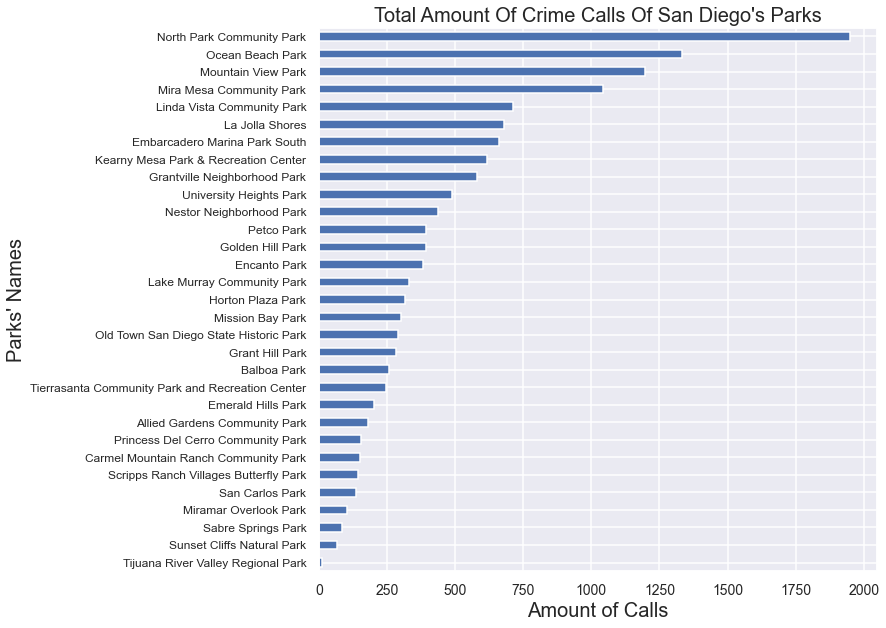

In [59]:
cl_park_data.sort_values('total_call').plot(x='name', y='total_call', kind='barh',figsize=(10,10), legend=False)
plt.title("Total Amount Of Crime Calls Of San Diego's Parks", size=20)
plt.xlabel('Amount of Calls', size=20)
plt.ylabel("Parks' Names", size=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)
f1 = plt.gcf()

In [60]:
grouped_by_hour = cl_park_data.groupby('median_close_hour', as_index=False)
grouped_by_hour = grouped_by_hour.sum().sort_values('median_close_hour').reset_index(drop=True)

In [61]:
grouped_by_hour

,median_close_hour,total_call,during,not_during
0,17.0,518,189,329
1,18.0,439,216,223
2,18.5,392,159,233
3,20.0,1314,734,580
4,21.0,2393,1131,1262
5,22.0,643,455,188
6,22.5,662,461,201
7,23.0,384,317,67
8,24.0,7391,7307,84


By just looking at this table above, we already have a sense of what the distribution will look like. We can see that this would be a normal distribution until the median_close_hour is 24. In other words, 24 is an outlier here because we saw that the parks that have the highest total crime calls are often those that open 24 hours or close at midnight.

Now, let's try to visualize the relationship between median close hour and the total amount of calls and the amount of calls during that occured during the operating hour.

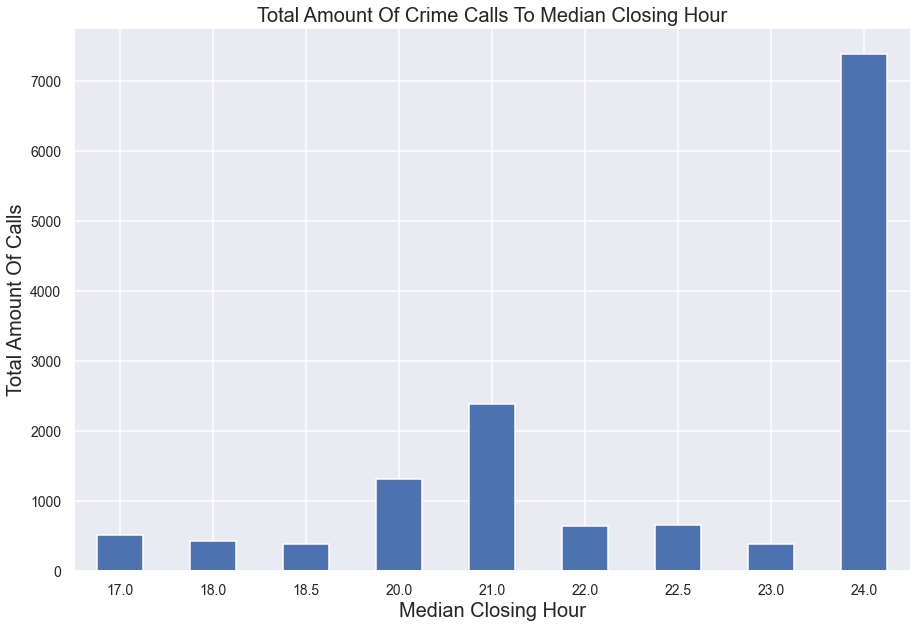

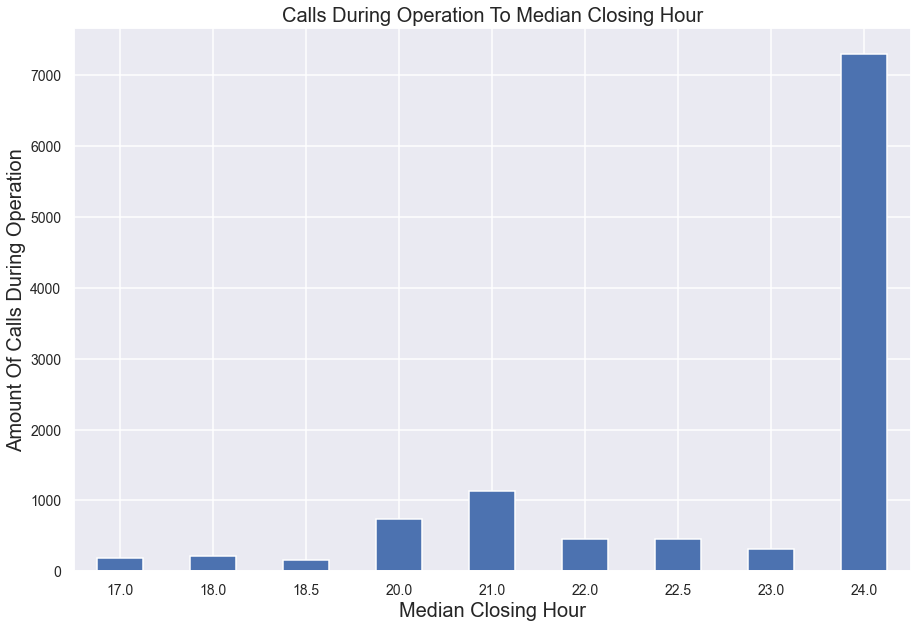

In [62]:
# Total Amount of Calls
grouped_by_hour.sort_values('median_close_hour').plot(x='median_close_hour',y='total_call', rot=0,
                                                      kind='bar', figsize=(15,10), legend=False)
plt.title("Total Amount Of Crime Calls To Median Closing Hour", size=20)
plt.xlabel('Median Closing Hour', size=20)
plt.ylabel('Total Amount Of Calls', size=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
f2 = plt.gcf()

# Amount of Calls During Operation Hour
grouped_by_hour.sort_values('median_close_hour').plot(x='median_close_hour',y='during', rot=0,
                                                      kind='bar', figsize=(15,10), legend=False)
plt.title("Calls During Operation To Median Closing Hour", size=20)
plt.xlabel('Median Closing Hour', size=20)
plt.ylabel('Amount Of Calls During Operation', size=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
f3 = plt.gcf()

As we expected, the distribution is fairly normal up until the median close hour is 24. Now, let's find out how many calls that are from parks that open all day OR close at midnight.

Here, I'm attempting to categorize the median closing hours into 'early' and 'late' in terms of my own consideration for early and late closing hour. An early hour is less than or equal to 20 (or 8pm), a late hour is less than 24 (midnight) AND greater than 20 (8pm), and a midnight hour is around 24. These categories will be put into a new column called 'status'.

In [63]:
grouped_by_hour['status'] = ''

In [64]:
for i in grouped_by_hour['median_close_hour']:
    if i <= 20.0:
        grouped_by_hour.loc[grouped_by_hour['median_close_hour'] == i, 'status'] = 'early'
    elif (i > 20.0) & (i < 24.0):
        grouped_by_hour.loc[grouped_by_hour['median_close_hour'] == i, 'status'] = 'late'
    else:
        grouped_by_hour.loc[grouped_by_hour['median_close_hour'] == i, 'status'] = 'midnight'

In [65]:
grouped_by_status = grouped_by_hour.groupby('status', as_index=False)
grouped_by_status = grouped_by_status.sum()

In [66]:
grouped_by_status

,status,median_close_hour,total_call,during,not_during
0,early,73.5,2663,1298,1365
1,late,88.5,4082,2364,1718
2,midnight,24.0,7391,7307,84


As we can see, those that open all day OR close at midnight contribute a huge portion to the total amount of crime calls. Now, let's try to plot these values to better visualize the relationship.

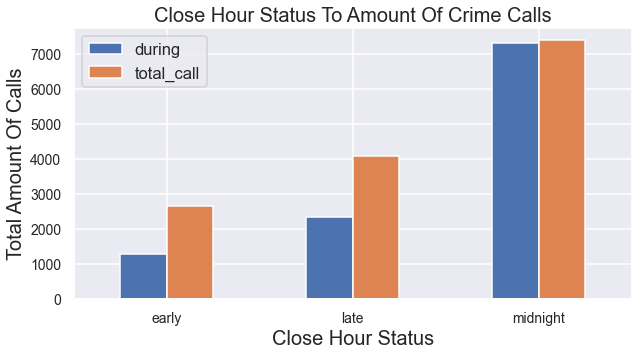

In [67]:
grouped_by_status.plot(x='status', y=['during','total_call'], kind='bar', figsize=(10,5), rot=0, legend=True)
plt.title('Close Hour Status To Amount Of Crime Calls', size=20)
plt.xlabel('Close Hour Status', size=20)
plt.ylabel('Total Amount Of Calls', size=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
f4 = plt.gcf()

Here, we can see that there is a huge jump in both the total amount of calls and the calls that occured within the operating hour for parks that open all day OR close at midnight. Let's us now find out more about this jump. Let's first look at all of those that satisfy this operating hour from our cl_park_data.

In [68]:
close_midnight_parks = cl_park_data[cl_park_data['median_close_hour'] == 24]
close_midnight_parks = close_midnight_parks.reset_index(drop=True)
close_midnight_parks

,name,neighborhood,total_call,mon,tue,wed,thur,fri,sat,sun,during,not_during,median_close_hour
0,Mountain View Park,Mountain View,1196,0-24,0-24,0-24,0-24,0-24,0-24,0-24,1196,0,24.0
1,Grantville Neighborhood Park,Grantville,581,0-24,0-24,0-24,0-24,0-24,0-24,0-24,581,0,24.0
2,La Jolla Shores,La Jolla,681,0-24,0-24,0-24,0-24,0-24,0-24,0-24,681,0,24.0
3,Mission Bay Park,Mission Bay Park,303,4-24,4-24,4-24,4-24,4-24,4-24,4-24,270,33,24.0
4,Balboa Park,Balboa Park,258,0-24,0-24,0-24,0-24,0-24,0-24,0-24,258,0,24.0
5,Grant Hill Park,Grant Hill,284,0-24,0-24,0-24,0-24,0-24,0-24,0-24,284,0,24.0
6,Horton Plaza Park,Horton Plaza,317,5-24,5-24,5-24,5-24,5-24,5-24,5-24,266,51,24.0
7,Sunset Cliffs Natural Park,Sunset Cliffs,66,0-24,0-24,0-24,0-24,0-24,0-24,0-24,66,0,24.0
8,North Park Community Park,North Park,1950,0-24,0-24,0-24,0-24,0-24,0-24,0-24,1950,0,24.0
9,Mira Mesa Community Park,Mira Mesa,1041,0-24,0-24,0-24,0-24,0-24,0-24,0-24,1041,0,24.0


Now, let's look at those that do not open all day but close at midnight. We can see that from the table above, 2 parks are not open all day but close at midnight. They are Mission Bay Park and Horton Plaza Park.

Let's look at how often crime calls of these areas are made and from what hour. We will be using the filtered_crimes and the neighborhood column in close_midnight_parks here.

In [69]:
hour_occurence = []

for neighborhood in close_midnight_parks['neighborhood']:
    hour_list = pd.to_datetime(filtered_crimes.loc[filtered_crimes['name'] == neighborhood, 'date_time']).dt.strftime('%H').tolist()
    hour_list = list(map(int, hour_list))
    hour_occurence += hour_list

In [70]:
len(hour_occurence)

7391

Now, let's try to count the frequency of each occurence.

In [71]:
hour_freq_midnight = pd.DataFrame(Counter(hour_occurence).items(), columns=['hour', 'frequency'])
hour_freq_midnight = hour_freq_midnight.sort_values('hour').reset_index(drop=True)

In [72]:
hour_freq_midnight

,hour,frequency
0,0,390
1,1,304
2,2,254
3,3,151
4,4,118
5,5,79
6,6,100
7,7,113
8,8,184
9,9,251


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


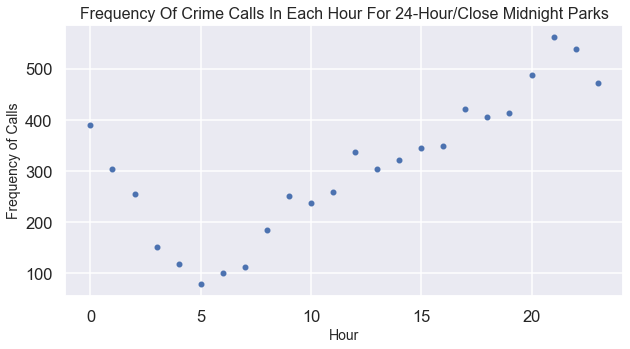

In [73]:
hour_freq_midnight.plot(x='hour', y='frequency', kind='scatter', figsize=(10,5))
plt.title('Frequency Of Crime Calls In Each Hour For 24-Hour/Close Midnight Parks', fontsize=16)
plt.xlabel('Hour', fontsize=14)
plt.ylabel('Frequency of Calls', fontsize=14)
f5 = plt.gcf()

Looking at this scatterplot, we can see that the frequency is high when the hour is 0. The frequency then starts to decrease toward the hour 5 mark and starts to increase again all the way up to midnight. This means that crime calls happen more often around midnight and very early morning (around hour 0 to 1). But let's dig a little deeper here and see if other categories, 'early' and 'late', have the same pattern of frequency. 

In [74]:
close_early_parks = cl_park_data[cl_park_data['median_close_hour'] <= 20]
close_early_parks = close_early_parks.reset_index(drop=True)

close_late_parks = cl_park_data[(cl_park_data['median_close_hour'] > 20) & (cl_park_data['median_close_hour'] < 24)]
close_late_parks = close_late_parks.reset_index(drop=True)

In [75]:
hour_occurence_early = []
hour_occurence_late = []

# Get the hour for close early parks
for neighborhood in close_early_parks['neighborhood']:
    hour_list = pd.to_datetime(filtered_crimes.loc[filtered_crimes['name'] == neighborhood, 'date_time']).dt.strftime('%H').tolist()
    hour_list = list(map(int, hour_list))
    hour_occurence_early += hour_list

# Get the hour for close late parks
for neighborhood in close_late_parks['neighborhood']:
    hour_list = pd.to_datetime(filtered_crimes.loc[filtered_crimes['name'] == neighborhood, 'date_time']).dt.strftime('%H').tolist()
    hour_list = list(map(int, hour_list))
    hour_occurence_late += hour_list

In [76]:
hour_freq_early = pd.DataFrame(Counter(hour_occurence_early).items(), columns=['hour', 'frequency'])
hour_freq_early = hour_freq_early.sort_values('hour').reset_index(drop=True)

hour_freq_late = pd.DataFrame(Counter(hour_occurence_late).items(), columns=['hour', 'frequency'])
hour_freq_late = hour_freq_late.sort_values('hour').reset_index(drop=True)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


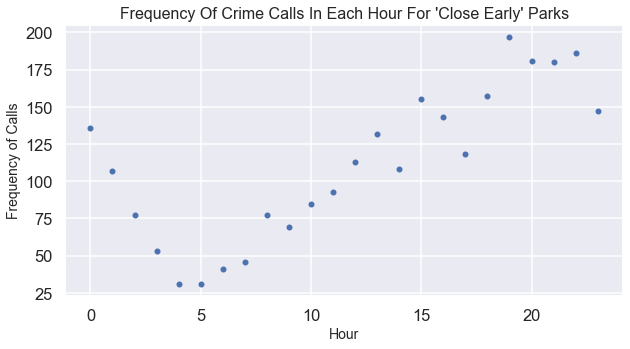

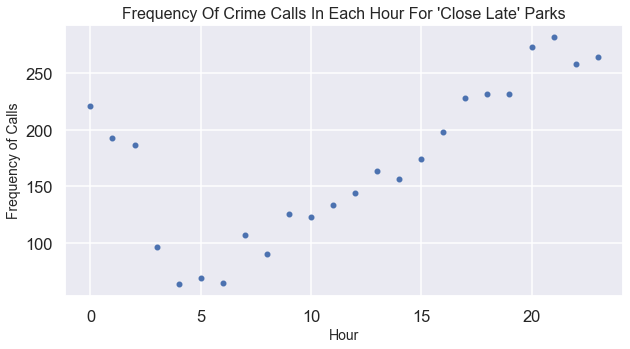

In [77]:
hour_freq_early.plot(x='hour', y='frequency', kind='scatter', figsize=(10,5))
plt.title("Frequency Of Crime Calls In Each Hour For 'Close Early' Parks", fontsize=16)
plt.xlabel('Hour', fontsize=14)
plt.ylabel('Frequency of Calls', fontsize=14)
f6 = plt.gcf()

hour_freq_late.plot(x='hour', y='frequency', kind='scatter', figsize=(10,5))
plt.title("Frequency Of Crime Calls In Each Hour For 'Close Late' Parks", fontsize=16)
plt.xlabel('Hour', fontsize=14)
plt.ylabel('Frequency of Calls', fontsize=14)
f7 = plt.gcf()

We can see that these categories also have similar pattern of frequency. However, this does not fully answer our question yet. They just show that crime calls are more frequent around midnight to very early morning. We can see, though, that the pattern is tighter for parks with late close hour. Let's go back to the grouped_by_status table and look at the relationship between calls that were actually made during the operating hour and the closing status of each park.

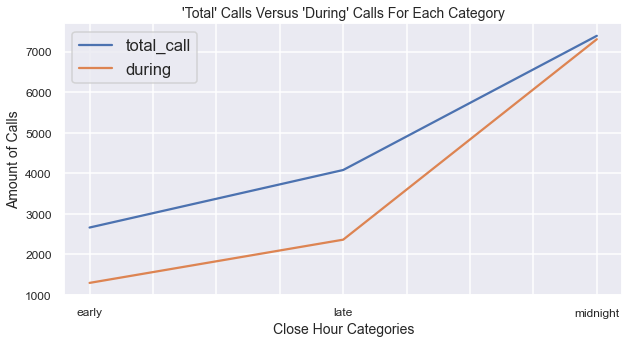

In [78]:
grouped_by_status.plot(x='status', y=['total_call','during'], figsize=(10,5))
plt.title("'Total' Calls Versus 'During' Calls For Each Category", fontsize=14)
plt.xlabel('Close Hour Categories', fontsize=14)
plt.ylabel('Amount of Calls', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
f8 = plt.gcf()

From just looking at this plot, we can see that areas with later parks' median closing hour tend to have more total crime calls, and as a result tend have more crime calls during the parks' operating hour. To see this more clearly, let's look at the percentage of calls that were made during the operating hour of each category.

In [79]:
# Percentage of 'during' calls for 'close early' parks
total_early = grouped_by_status.loc[grouped_by_status['status'] == 'early', 'total_call']
during_early = grouped_by_status.loc[grouped_by_status['status'] == 'early', 'during']
close_early_perc = (during_early / total_early) * 100

# Percentage of 'during' calls for 'close late' parks
total_late = grouped_by_status.loc[grouped_by_status['status'] == 'late', 'total_call']
during_late = grouped_by_status.loc[grouped_by_status['status'] == 'late', 'during']
close_late_perc = (during_late / total_late) * 100

# Percentage of 'during calls' for 'close midnight/open 24hr' parks
total_midnight = grouped_by_status.loc[grouped_by_status['status'] == 'midnight', 'total_call']
during_midnight = grouped_by_status.loc[grouped_by_status['status'] == 'midnight', 'during']
close_midnight_perc = (during_midnight / total_midnight) * 100

In [80]:
close_early_perc = close_early_perc.reset_index(drop=True)[0]
close_late_perc = close_late_perc.reset_index(drop=True)[0]
close_midnight_perc = close_midnight_perc.reset_index(drop=True)[0]

In [81]:
grouped_by_status['during_perc'] = [close_early_perc, close_late_perc, close_midnight_perc]

In [82]:
grouped_by_status

,status,median_close_hour,total_call,during,not_during,during_perc
0,early,73.5,2663,1298,1365,48.74
1,late,88.5,4082,2364,1718,57.91
2,midnight,24.0,7391,7307,84,98.86


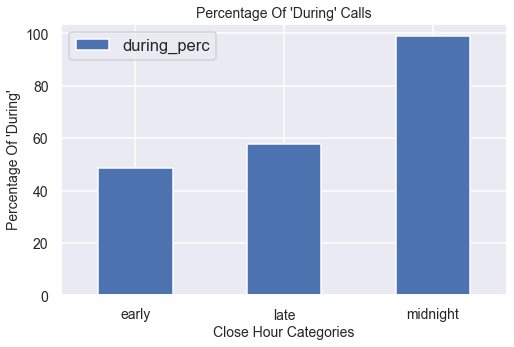

In [83]:
grouped_by_status.plot(x='status', y='during_perc', kind='bar', rot=0, figsize=(8,5))
plt.title("Percentage Of 'During' Calls", fontsize=14)
plt.xlabel('Close Hour Categories', fontsize=14)
plt.ylabel("Percentage Of 'During'", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
f9 = plt.gcf()

This shows us that there is clearly a pattern going on here. We have repeatedly seen through these plots that there is an increasing trend in the total amount of crime calls as the median closing hour increases. Not only that, the percentage of crime calls that were made during the parks' operating hour also seem to increase with the median closing hour. With these in mind, let's look back at each individual park, calculate their 'during' percentage, and create a statsmodel that could give us an evaluation on whether or not there is a correlation between the median closing hour and the amount of crime.

In [84]:
# This function basically calculates the percentage given the 'total' and 'during' calls
def find_percentage(name):
    total = cl_park_data.loc[cl_park_data['name'] == name, 'total_call']
    during = cl_park_data.loc[cl_park_data['name'] == name, 'during']
    return ((during/total) * 100).values[0]

In [85]:
cl_park_data['during_perc'] = cl_park_data['name'].apply(find_percentage)

In [86]:
cl_park_data.head()

,name,neighborhood,total_call,mon,tue,wed,thur,fri,sat,sun,during,not_during,median_close_hour,during_perc
0,Mountain View Park,Mountain View,1196,0-24,0-24,0-24,0-24,0-24,0-24,0-24,1196,0,24.0,100.00
1,Grantville Neighborhood Park,Grantville,581,0-24,0-24,0-24,0-24,0-24,0-24,0-24,581,0,24.0,100.00
2,Petco Park,Petco Park,392,9-21,9-21,9-21,9-21,9-21,9-21,9-21,263,129,21.0,67.09
3,Ocean Beach Park,Ocean Beach,1331,10-21,10-21,10-21,10-21,10-19,9-16,0-0,582,749,21.0,43.73
4,Embarcadero Marina Park South,Marina,662,6-22.5,6-22.5,6-22.5,6-22.5,6-22.5,6-22.5,6-22.5,461,201,22.5,69.64


Let's first plot the median_close_hour with the during_perc we just created to determine their correlation.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


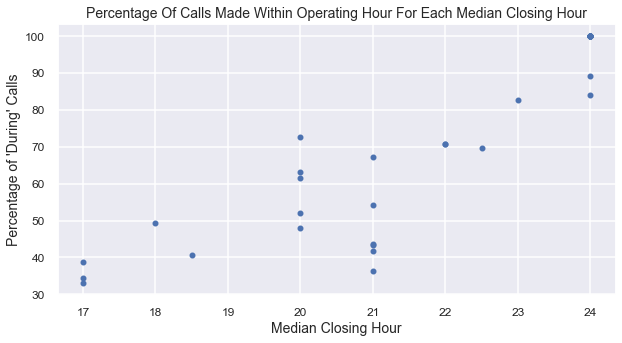

In [87]:
cl_park_data.plot(x='median_close_hour', y='during_perc', kind='scatter', figsize=(10,5))
plt.title("Percentage Of Calls Made Within Operating Hour For Each Median Closing Hour", fontsize=14)
plt.xlabel('Median Closing Hour', fontsize=14)
plt.ylabel("Percentage of 'During' Calls", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
f10 = plt.gcf()

In [88]:
#np.corrcoef(cl_park_data['median_close_hour'], cl_park_data['during_perc'])
cl_park_data.corr()

,total_call,during,not_during,median_close_hour,during_perc
total_call,1.00,0.94,0.24,0.38,0.37
during,0.94,1.00,-0.10,0.53,0.57
not_during,0.24,-0.10,1.00,-0.38,-0.54
median_close_hour,0.38,0.53,-0.38,1.00,0.89
during_perc,0.37,0.57,-0.54,0.89,1.00


As we can see here, the correlation is pretty high (around 0.89). Thus, we can assume that there is a strong positive correlation between the median closing hour and the amount of calls that were made during each park's operating hour. NOTE: This includes all parks listed in the cl_park_data.

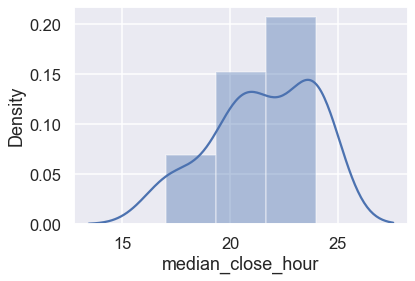

In [89]:
sns.distplot(cl_park_data['median_close_hour'])
f11 = plt.gcf()

Applying the normal test, we know that the distribution above is fairly normal.

In [90]:
statistic_1, p_val_1 = normaltest(cl_park_data['median_close_hour'])
if p_val_1 < 0.05:
    print('We reject the null - not normal')
else:
    print('We fail to reject the null - normal')

We fail to reject the null - normal


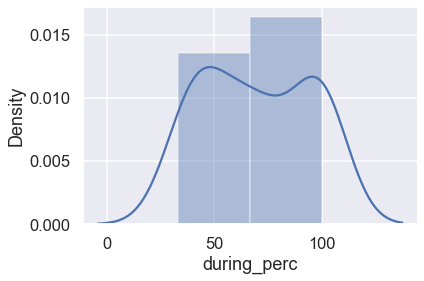

In [91]:
sns.distplot(cl_park_data['during_perc'])
f12 = plt.gcf()

In [92]:
statistic_2, p_val_2 = normaltest(cl_park_data['during_perc'])
if p_val_2 < 0.05:
    print('We reject the null - not normal')
else:
    print('We fail to reject the null - normal')

We reject the null - not normal


Even though the distribution of during_perc is not normal, I will just assume that it is and continue to perform the OLS and see if the distribution of the residuals is normal.

Now, we want to determine the p-value to make sure that these variables are indeed correlated. We will use the Ordinary Least Square (OLS) method to do this.

In [93]:
outcome_1, predictors_1 = patsy.dmatrices('during_perc ~ median_close_hour', cl_park_data)
model_1 = sm.OLS(outcome_1, predictors_1)
result_1 = model_1.fit()

In [94]:
print(result_1.summary())

                            OLS Regression Results                            
Dep. Variable:            during_perc   R-squared:                       0.790
Model:                            OLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                     108.8
Date:                Mon, 14 Dec 2020   Prob (F-statistic):           2.51e-11
Time:                        00:54:47   Log-Likelihood:                -118.64
No. Observations:                  31   AIC:                             241.3
Df Residuals:                      29   BIC:                             244.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          -130.1389     19.22

As we can see here, our p-value is extremely small, so we are able to reject the null hypothesis. Thus, we can say that the median_close_hour and during_perc are correlated. In addition, the R-squared is fairly high, which means that the median_close_hour explains 79% of the variation of the during_perc variable.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


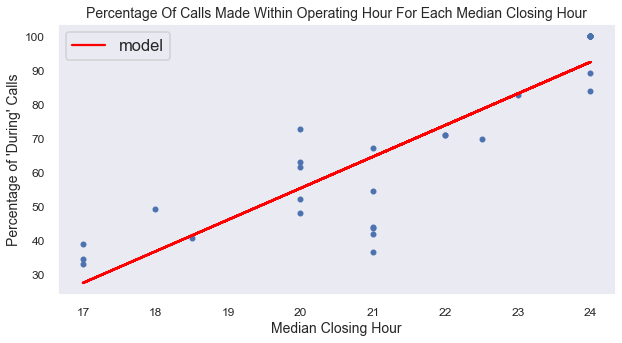

In [95]:
# Plot this model
x_vals = cl_park_data['median_close_hour']
y_vals = 9.2677 * x_vals - 130.1389

# Plot the scatterplot of the data first and then plot the model on top of that figure
cl_park_data.plot(x='median_close_hour', y='during_perc', kind='scatter',grid=False, figsize=(10,5))
plt.plot(x_vals, y_vals, color='red', label='model')
plt.legend()
plt.title("Percentage Of Calls Made Within Operating Hour For Each Median Closing Hour", fontsize=14)
plt.xlabel('Median Closing Hour', fontsize=14)
plt.ylabel("Percentage of 'During' Calls", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
f13 = plt.gcf()

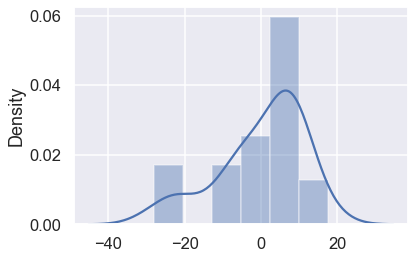

In [96]:
sns.distplot(result_1.resid)
f14 = plt.gcf()

In [97]:
statistic_3, p_val_3 = normaltest(result_1.resid)
if p_val_3 < 0.05:
    print('We reject the null - not normal')
else:
    print('We fail to reject the null - normal')

We fail to reject the null - normal


So this shows that even though our dependent variable was not normally distributed despite multiple hidden attempts at transforming it, the residuals of our OLS model is normally distributed at the end. This means that the non-normality of the dependent variable did not influence our result that much.

Let's also look at the correlation between the median_close_hour and the total_call variables. First, we need to see if the total_call is normally distributed.

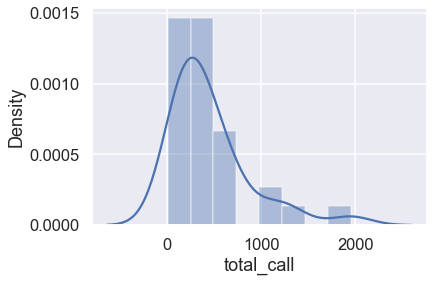

In [98]:
sns.distplot(cl_park_data['total_call'])
f15 = plt.gcf()

In [99]:
statistic_4, p_val_4 = normaltest(cl_park_data['total_call'])
if p_val_4 < 0.05:
    print('We reject the null - not normal')
else:
    print('We fail to reject the null - normal')

We reject the null - not normal


In [100]:
# Transform the total_call so that it is normally distributed
cl_park_data['total_call_log10_square'] = np.square(np.log10(cl_park_data['total_call']))

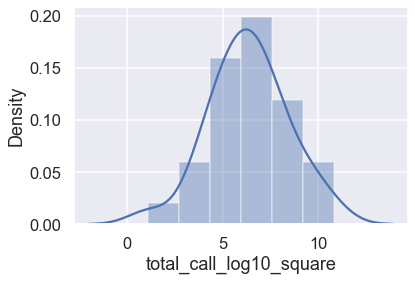

In [101]:
sns.distplot(cl_park_data['total_call_log10_square'])
f16 = plt.gcf()

In [102]:
statistic_5, p_val_5 = normaltest(cl_park_data['total_call_log10_square'])
if p_val_5 < 0.05:
    print('We reject the null - not normal')
else:
    print('We fail to reject the null - normal')

We fail to reject the null - normal


Now that we successfully transformed the distribution into a normal distribution, we will proceed to creating an OLS model.

In [103]:
outcome_2, predictors_2 = patsy.dmatrices('total_call_log10_square ~ median_close_hour', cl_park_data)
model_2 = sm.OLS(outcome_2, predictors_2)
result_2 = model_2.fit()

In [104]:
print(result_2.summary())

                               OLS Regression Results                              
Dep. Variable:     total_call_log10_square   R-squared:                       0.155
Model:                                 OLS   Adj. R-squared:                  0.126
Method:                      Least Squares   F-statistic:                     5.317
Date:                     Mon, 14 Dec 2020   Prob (F-statistic):             0.0285
Time:                             00:54:48   Log-Likelihood:                -63.173
No. Observations:                       31   AIC:                             130.3
Df Residuals:                           29   BIC:                             133.2
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

This shows a p-value is less than 0.05. Because of this, we can reject the null hypothesis and this means that there is a correlation between median_close_hour and total_call. However, the R-squared value is very low, which means that the median_close_hour does not explain much about the variation of the total_call.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


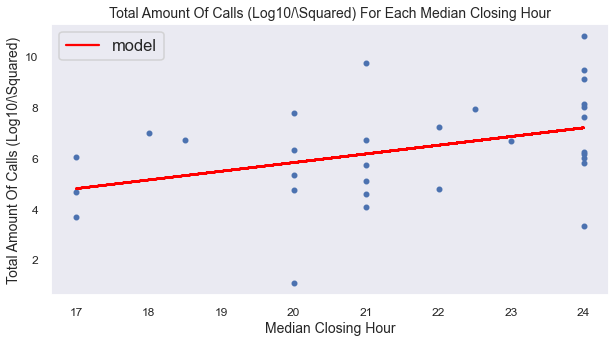

In [105]:
# Plot this model
x_vals_2 = cl_park_data['median_close_hour']
y_vals_2 = 0.3423 * x_vals_2 - 1.0162

# Plot the scatterplot of the data first and then plot the model on top of that figure
cl_park_data.plot(x='median_close_hour', y='total_call_log10_square', kind='scatter',grid=False, figsize=(10,5))
plt.plot(x_vals_2, y_vals_2, color='red', label='model')
plt.legend()
plt.title("Total Amount Of Calls (Log10/\Squared) For Each Median Closing Hour", fontsize=14)
plt.xlabel('Median Closing Hour', fontsize=14)
plt.ylabel("Total Amount Of Calls (Log10/\Squared)", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
f17 = plt.gcf()

As expected, the model does not explain a lot about the variance of the outcome variable, which is total_call

Now, let's look at the residuals plot.

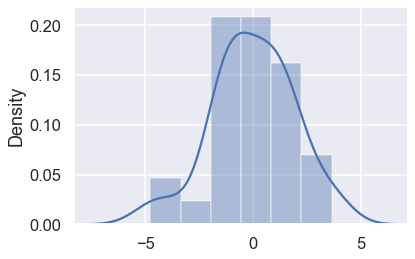

In [106]:
sns.distplot(result_2.resid)
f18 = plt.gcf()

In [107]:
statistic_6, p_val_6 = normaltest(result_2.resid)
if p_val_6 < 0.05:
    print('We reject the null - not normal')
else:
    print('We fail to reject the null - normal')

We fail to reject the null - normal


However, the residual plot at the end is fairly normal. So we can say that the model does describe the relationship between median_close_hour and total_call, but very poorly.

# Ethics & Privacy

*Fill in your ethics & privacy discussion here*

# Conclusion & Discussion

*Fill in your discussion information here*